In [1]:
import os
import random
import tensorflow as tf
from keras.models import load_model
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

# Constants

In [2]:
IMG_WIDTH = 768
IMG_HEIGHT = 768
IMG_CHANNELS = 3
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
epochs=10
batch_size=32
image_shape=(768, 768)
FAST_RUN=True # use for development only
FAST_PREDICTION=True # use for development only

In [3]:
TRAIN_IMAGES_PATH = '../input/airbus-ship-detection/train_v2/'
TEST_IMAGES_PATH = '../input/airbus-ship-detection/test_v2'

In [4]:
MODEL_PATH = "../input/winstars-model-tr/model.h5"

In [5]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

# Load model

In [6]:
model = load_model(MODEL_PATH,
                   custom_objects={'dice_coef':dice_coef})

2022-08-23 09:43:57.636074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 09:43:57.756630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 09:43:57.757446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 09:43:57.759260: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
IMG_SIZE=128
# Get and resize test images
sample_submission = pd.read_csv('../input/airbus-ship-detection/sample_submission_v2.csv')
test_ids = sample_submission['ImageId'].unique().tolist()

X_test = np.zeros((sample_submission['ImageId'].nunique(), IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
print('Getting and resizing test images ... ')

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = f'../input/airbus-ship-detection/test_v2/{id_}'
    img = imread(path)[:,:]
    img = resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis = 0)
    X_test[n] = img

print('Done!')

print(X_test.shape)

Getting and resizing test images ... 


100%|██████████| 15606/15606 [20:44<00:00, 12.54it/s]

Done!
(15606, 128, 128, 3)


In [8]:
preds_test = model.predict(X_test, verbose=1)

2022-08-23 10:04:51.455244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-23 10:04:52.814830: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


488/488 [==============================] - 47s 80ms/step


2022-08-23 10:05:38.275322: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1022754816 exceeds 10% of free system memory.


# Show results

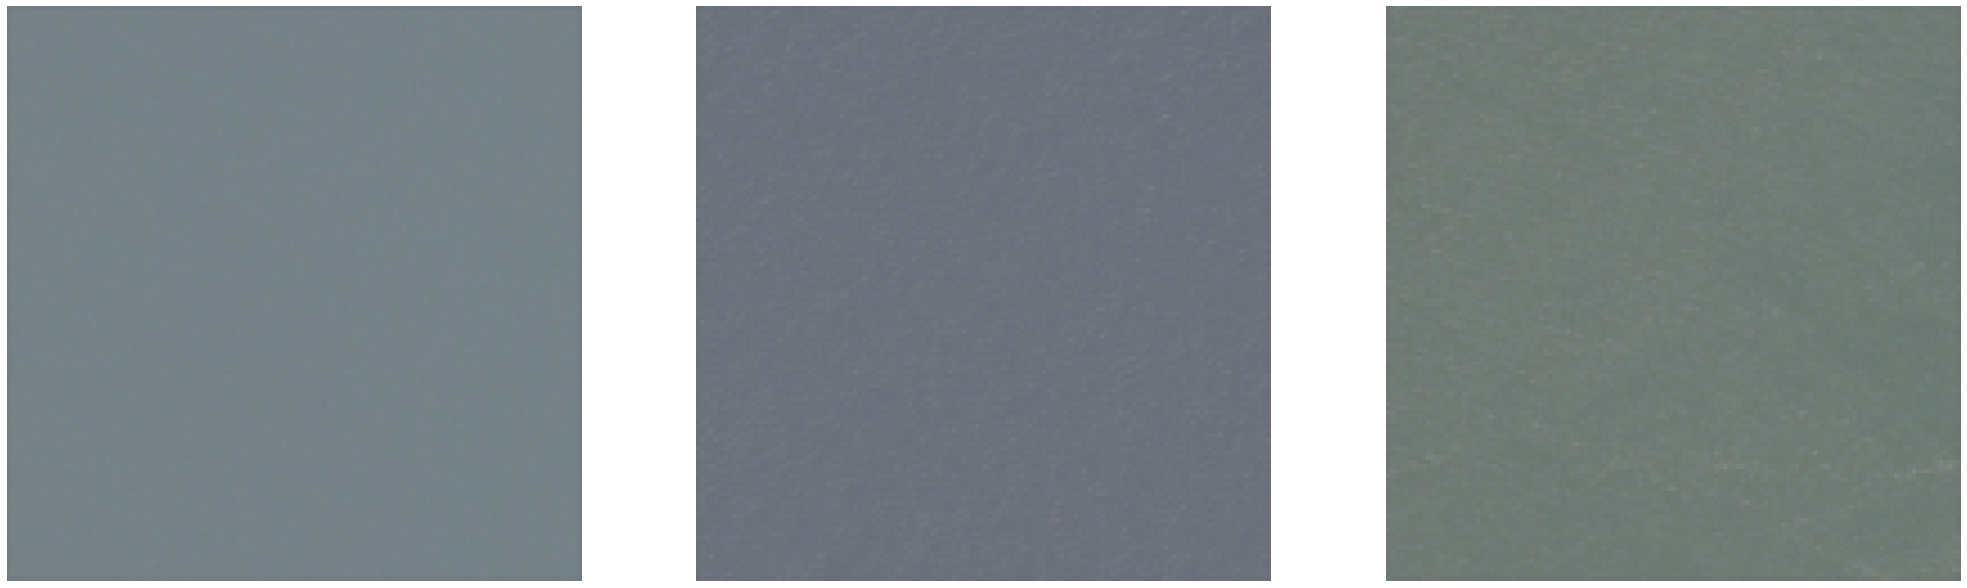

In [9]:
threshold=0.5
max_images = 3
grid_width = 3

grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(35, 35))
for i, idx in enumerate(preds_test[:max_images]):
    ax = axs[i]
    img = X_test[i]
    ax.imshow(img)
    
    pred = (preds_test[i] > threshold).astype(np.float32)
    ax.imshow(pred, alpha=0.4, cmap="Reds")
    
    ax.axis('off')